In [27]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the parent directory to the Python path
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Import modules
import loss.functions
import auxiliar.filterbanks

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Load audio to filter -----------------------------------
fire_path  = ".."+"/sounds/fire.wav"
water_path = ".."+"/sounds/water.wav"
sr = 44100
fire_audio, _  = librosa.load(fire_path, sr=sr)
water_audio, _ = librosa.load(water_path, sr=sr)
# Make list of segments for fire and water --------------
frame_size = 2**16
hop_size   = 2**16
fire_segments = []
water_segments = []
for i in range(0, len(fire_audio)-frame_size, hop_size):
    fire_segments.append(fire_audio[i:i+frame_size])
for i in range(0, len(water_audio)-frame_size, hop_size):
    water_segments.append(water_audio[i:i+frame_size])
# Initialize erb_bank and log_bank for statistics loss --
N_filterbank = 16
erb_bank = auxiliar.filterbanks.EqualRectangularBandwidth(frame_size, sr, N_filterbank, 20, sr // 2)
log_bank = auxiliar.filterbanks.Logarithmic(frame_size // 4, 11025, 6, 10, 11025 // 4)

In [29]:
#Testing Statistics functions --------------------------------------------------

fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
water_segment = water_segments[np.random.randint(len(water_segments))]
fire_segment  = torch.tensor(fire_segment)
water_segment = torch.tensor(water_segment)
fire_stats  = loss.functions.statistics(fire_segment, N_filterbank, sr, erb_bank, log_bank)
water_stats = loss.functions.statistics(water_segment, N_filterbank, sr, erb_bank, log_bank)
print("Fire statistics:\n")
print("stats_1:\n", fire_stats[0])
print("stats_2:\n", fire_stats[1])
print("stats_3:\n", fire_stats[2])
print("stats_4:\n", fire_stats[3])
print("stats_5:\n", fire_stats[4])
print("Water statistics:\n")
print("stats_1:\n", water_stats[0])
print("stats_2:\n", water_stats[1])
print("stats_3:\n", water_stats[2])
print("stats_4:\n", water_stats[3])
print("stats_5:\n", water_stats[4])

Fire statistics:

stats_1:
 tensor([[2.6945e+00, 4.6290e-01, 2.4824e-02, 1.0098e-02],
        [2.0479e+00, 3.3470e-01, 2.0731e-02, 9.1987e-03],
        [7.4520e-01, 4.2794e-01, 2.4590e-02, 1.0092e-02],
        [5.5009e-01, 5.6955e-01, 3.4823e-02, 1.9311e-02],
        [2.7322e-01, 1.2099e+00, 1.2690e-01, 1.2911e-01],
        [2.7498e-01, 1.2721e+00, 1.2679e-01, 1.3770e-01],
        [1.4695e-01, 4.1039e+00, 2.2690e-01, 3.5607e-01],
        [1.3300e-01, 5.1256e+00, 2.4609e-01, 4.1954e-01],
        [1.0080e-01, 9.9243e+00, 2.8712e-01, 5.8470e-01],
        [1.2676e-01, 7.2617e+00, 2.9002e-01, 5.7552e-01],
        [1.1038e-01, 1.0722e+01, 3.1262e-01, 6.3762e-01],
        [2.7298e-01, 2.9119e+00, 2.9638e-01, 6.1931e-01],
        [1.8210e-01, 8.7058e+00, 3.6985e-01, 9.2949e-01],
        [5.3977e-01, 1.5623e+00, 2.8452e-01, 7.0543e-01],
        [2.7682e-01, 5.1379e+00, 4.4616e-01, 1.4179e+00],
        [1.6123e+00, 5.9160e-01, 3.5205e-02, 2.6267e-02]])
stats_2:
 tensor([0.9305, 0.2103, 0.7538, 0

tensor(0.3053)
tensor(0.0266)
tensor(0.0171)
tensor(0.0037)
tensor(0.0124)


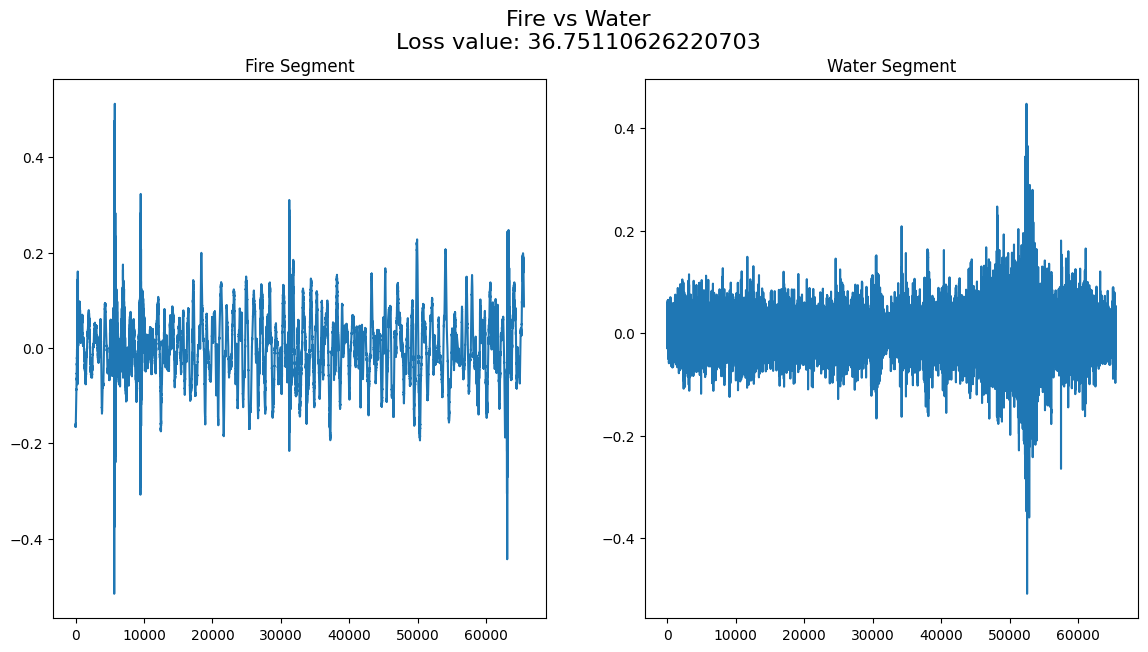

tensor(0.1801)
tensor(0.0309)
tensor(0.0152)
tensor(0.0036)
tensor(0.0131)


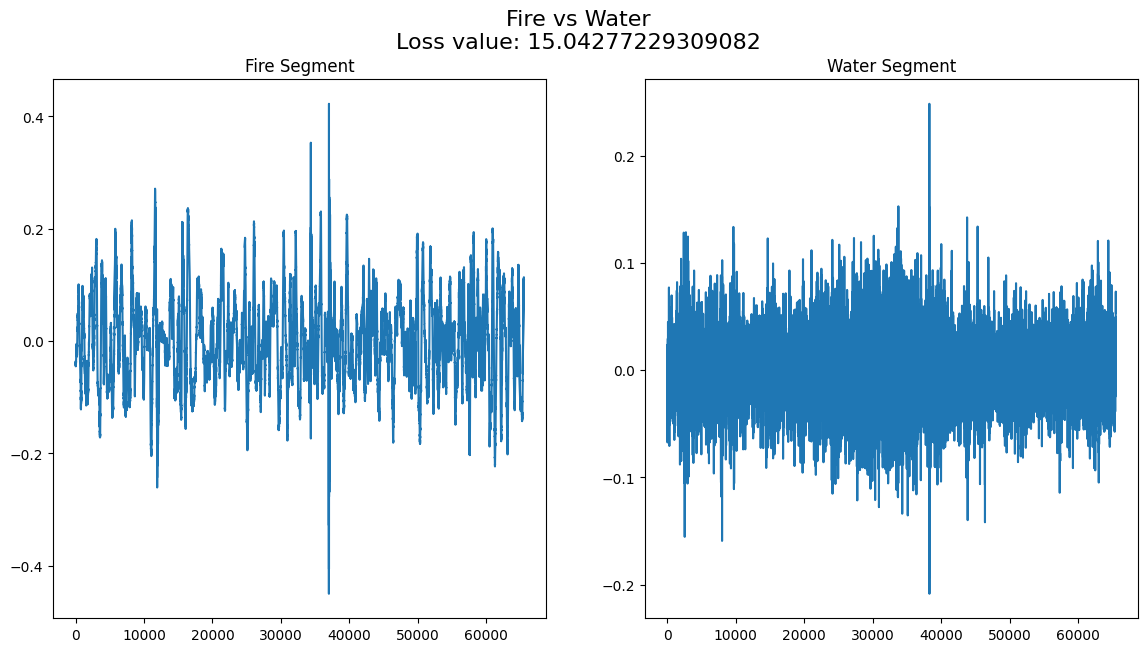

tensor(0.0724)
tensor(0.0304)
tensor(0.0165)
tensor(0.0043)
tensor(0.0127)


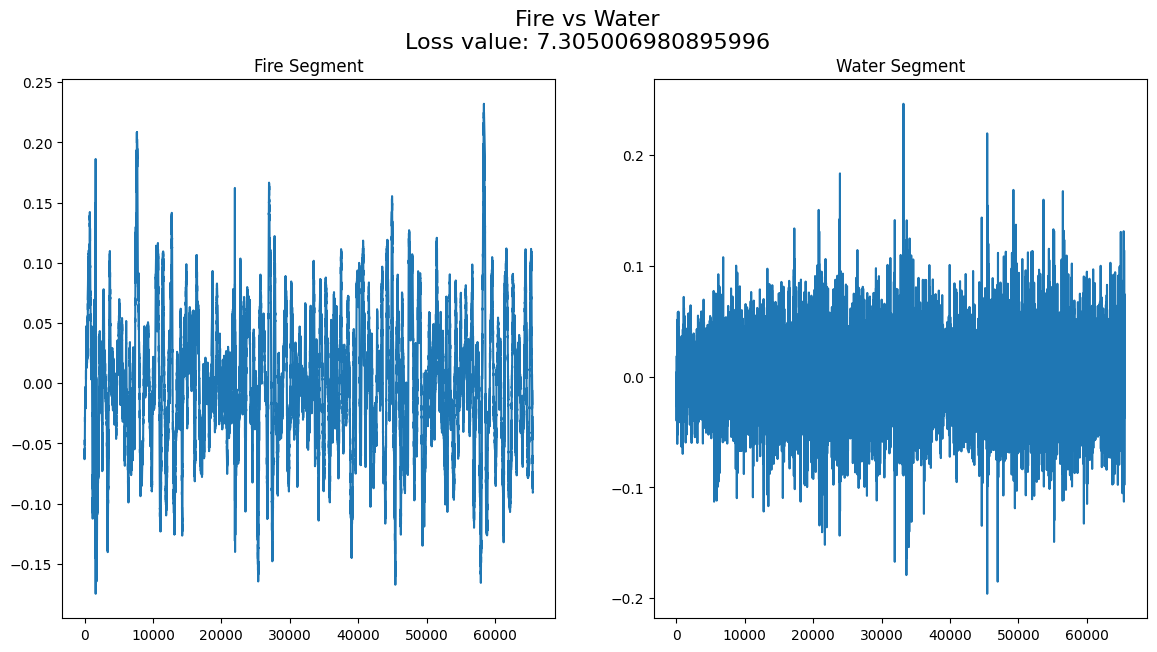

tensor(0.4977)
tensor(0.0099)
tensor(0.0050)
tensor(0.0024)
tensor(0.0074)


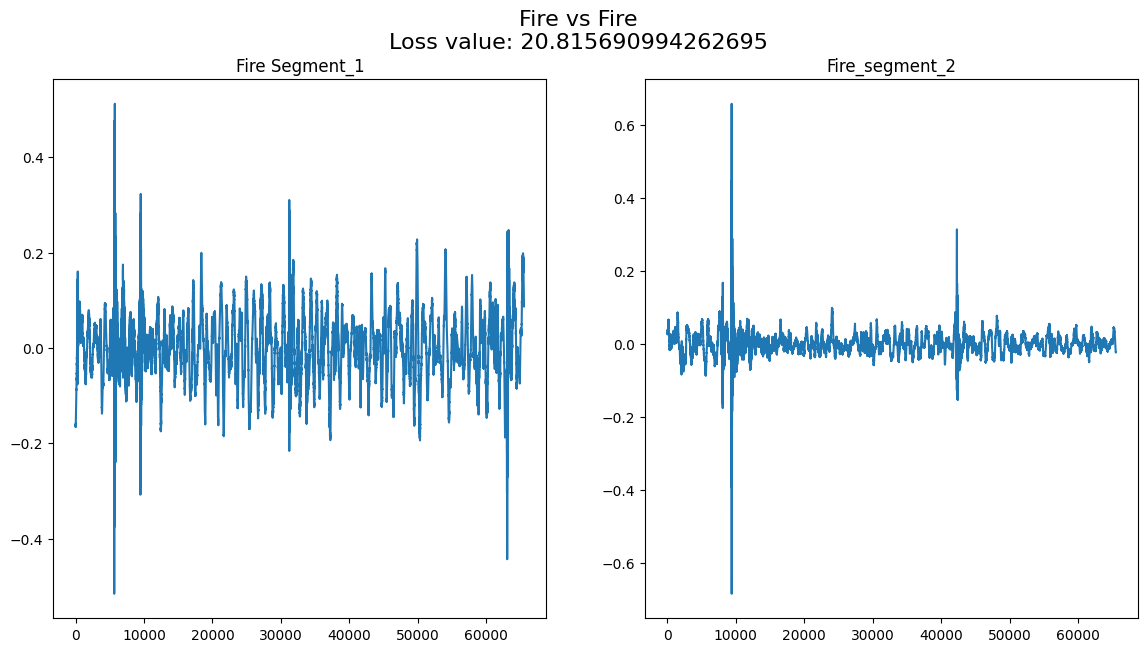

tensor(0.1536)
tensor(0.0184)
tensor(0.0071)
tensor(0.0019)
tensor(0.0082)


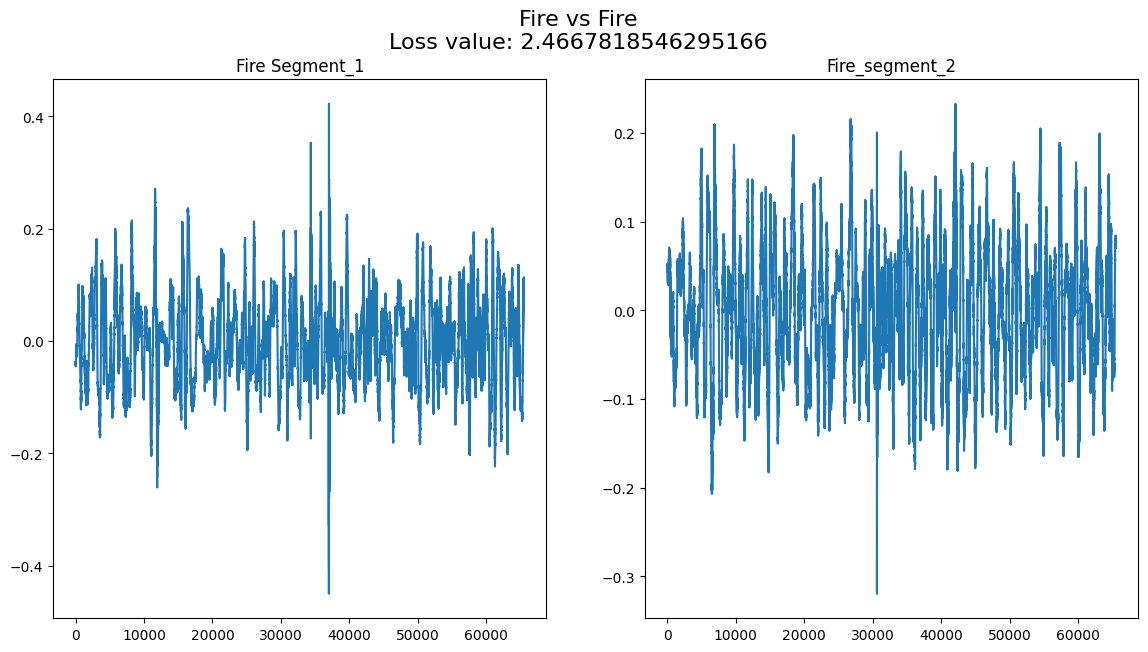

tensor(0.1131)
tensor(0.0137)
tensor(0.0066)
tensor(0.0027)
tensor(0.0074)


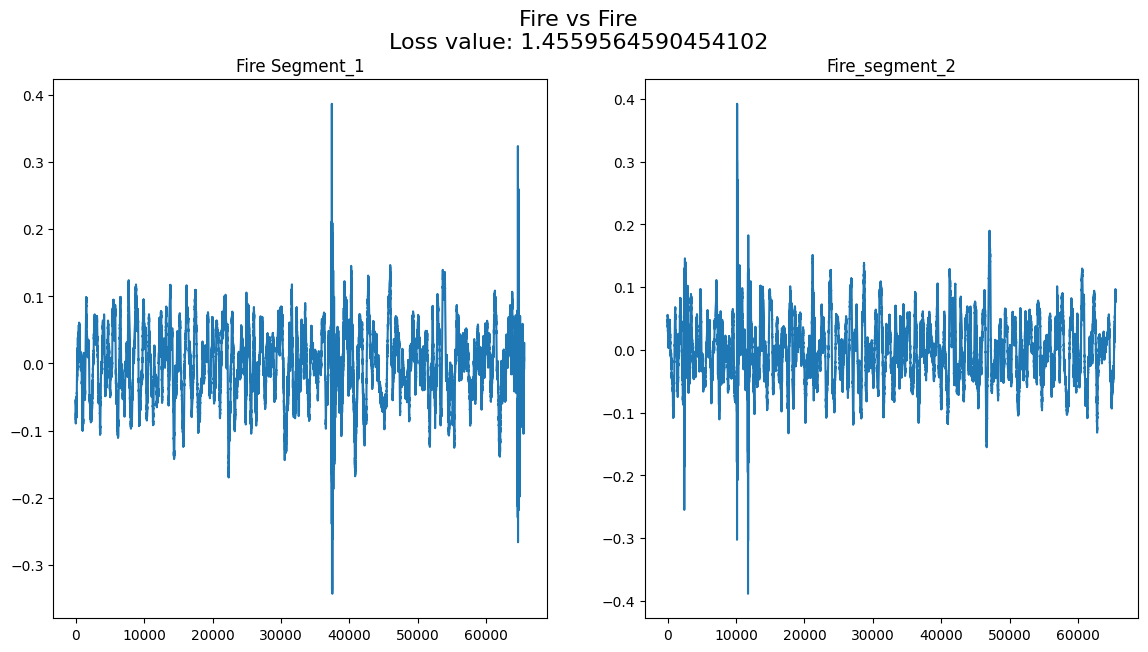

In [30]:
# Test Statistics loss function on three random pair of segments and plot them
for i in range(3):
    fire_segment  = fire_segments[np.random.randint(len(fire_segments))]
    water_segment = water_segments[np.random.randint(len(water_segments))]
    fire_segment  = torch.tensor(fire_segment)
    #play water and fire segments
    display(Audio(fire_segment, rate=sr))
    display(Audio(water_segment, rate=sr))
    water_segment = torch.tensor(water_segment)
    loss_value = loss.functions.statistics_loss(fire_segment, water_segment, 16, 44100, erb_bank, log_bank)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.plot(fire_segment)
    ax1.set_title('Fire Segment')
    ax2.plot(water_segment)
    ax2.set_title('Water Segment')
    fig.suptitle(f'Fire vs Water\nLoss value: {loss_value}', fontsize=16)
    plt.show()
# Test Statistics loss function on three random pair of fair
for i in range(3):
    fire_segment_1 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_2 = fire_segments[np.random.randint(len(fire_segments))]
    fire_segment_1 = torch.tensor(fire_segment_1)
    fire_segment_2 = torch.tensor(fire_segment_2)
    #play water and fire segments
    display(Audio(fire_segment_1, rate=sr))
    display(Audio(fire_segment_2, rate=sr))
    loss_value = loss.functions.statistics_loss(fire_segment_1, fire_segment_2, 16, 44100, erb_bank, log_bank)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.plot(fire_segment_1)
    ax1.set_title('Fire Segment_1')
    ax2.plot(fire_segment_2)
    ax2.set_title('Fire_segment_2')
    fig.suptitle(f'Fire vs Fire\nLoss value: {loss_value}', fontsize=16)
    plt.show()